In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
import time
import re
import os
import plotly.graph_objects as go
import gensim
import nltk
import en_core_web_sm
import spacy
from gensim.models import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
from scipy import stats
from collections import Counter
from nltk.corpus import stopwords
from gsdmm import MovieGroupProcess

# 1. Read data

In [4]:
#Reading all scraped tweets
df_all = pd.read_json('data_i-45_all.json', lines=True)

In [5]:
for i in ['df_all']:
    print(i)
    print('length:', len(globals()[i]))
    print('retweet:', round(np.mean(globals()[i].retweetCount),2))
    print('reply:', round(np.mean(globals()[i].replyCount),2))
    print('like:', round(np.mean(globals()[i].likeCount),2))
    print('------------------------')

df_all
length: 350275
retweet: 0.83
reply: 0.22
like: 2.29
------------------------


# 2. Filter tweets by related keywords to get the exact I-45 related tweets

In [21]:
filter_words=['txdot','expansion',
              'nhhip','stopi45','stopi-45',
              'fifth Ward','5th ward','east downtown','e downtown','e. downtown']

'''df=df_all[df_all['content'].str.contains('|'.join(filter_words),case=False)]
df=df.reset_index()
df=df.drop(['index'], axis=1)'''

"df=df_all[df_all['content'].str.contains('|'.join(filter_words),case=False)]\ndf=df.reset_index()\ndf=df.drop(['index'], axis=1)"

In [8]:
for i in ['df']:
    print(i)
    print('length:', len(globals()[i]))
    print('retweet:', round(np.mean(globals()[i].retweetCount),2))
    print('reply:', round(np.mean(globals()[i].replyCount),2))
    print('like:', round(np.mean(globals()[i].likeCount),2))
    print('------------------------')

df
length: 4103
retweet: 2.48
reply: 0.64
like: 8.18
------------------------


In [6]:
df = pd.read_pickle('alireza.pkl')

# 3. Slice date by creating individual columns for day, week, month, and year

In [7]:
df.date=pd.to_datetime(df.date)

m=[]
y=[]
w=[]
d=[]

for i in range(len(df)):
    m.append(df.date[i].month)
    y.append(df.date[i].year)
    w.append(df.date[i].week)
    d.append(df.date[i].day)
    
df['month'] = m
df['year'] = y
df['week'] = w
df['day'] = d

In [8]:
# Note: Twitter started in 2006
np.min(df.year)

2008

## 3.1. Plot the yearly Tweets from 2008 to 2021

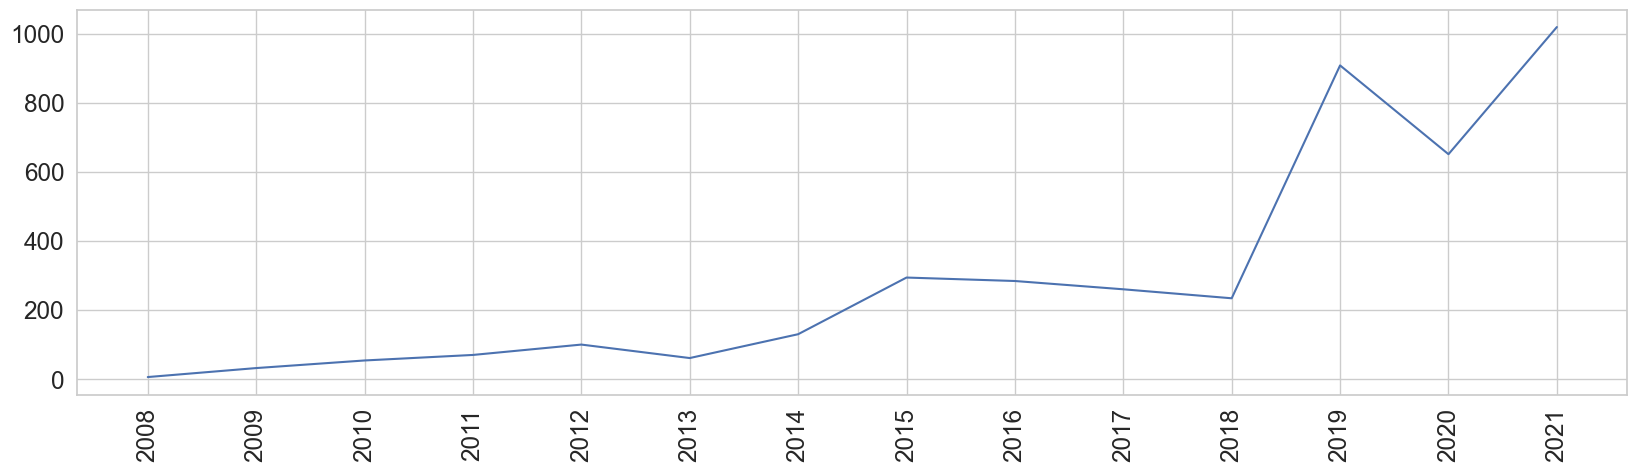

In [10]:
sns.set(style="whitegrid",font_scale=1.6)
plt.figure(figsize=(20,5))

trend_yr = []
years = np.arange(2008,2022)

for i in years:
    trend_yr = trend_yr + [len(df[df.year==i])]
    
plt.plot(trend_yr)
plt.xticks(list(np.arange(0,len(years))),list(years),rotation=90)

plt.show()

## 3.2. Plot the monthly Tweets from 2008 to 2021

In [11]:
trend_my = []
my_index = []
years = np.arange(2008,2022)
months = np.arange(1,13)

for i in years:
    for j in months:
        trend_my = trend_my + [len(df[(df.year==i) & (df.month==j)])]
        my_index = my_index + [(i,j)]

In [12]:
new_index = list(np.arange(0,len(my_index),12))
new_my = []

for k in new_index:
    new_my = new_my + [my_index[k]]

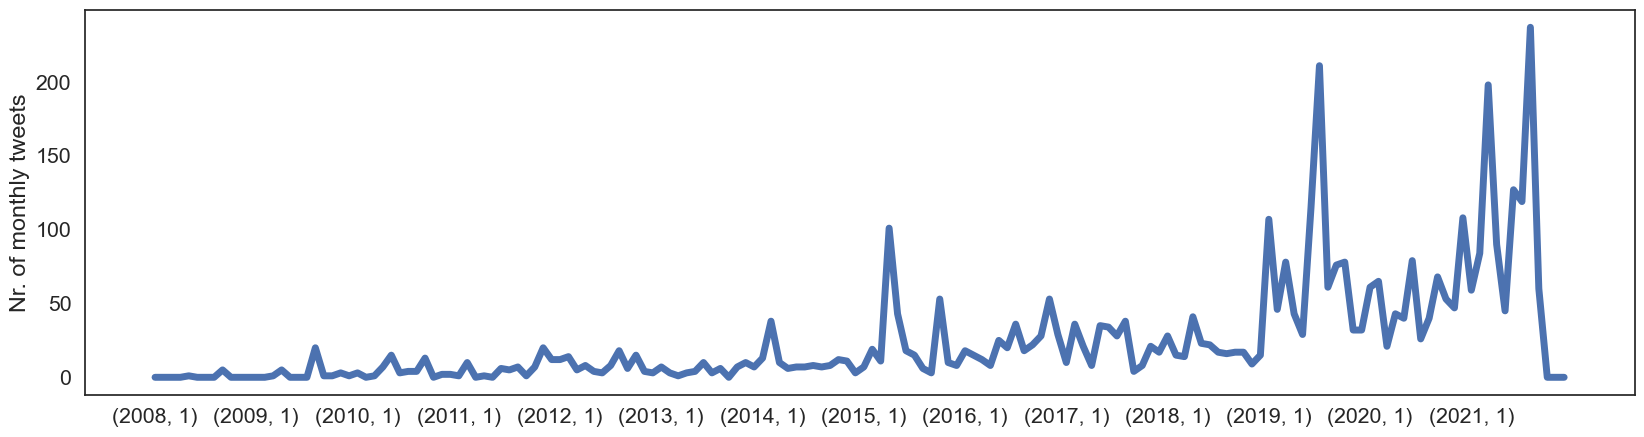

In [13]:
sns.set(style="white",font_scale=1.4)
plt.figure(figsize=(20,5))

plt.plot(np.arange(0,len(trend_my)),trend_my,linewidth=5)
plt.xticks(new_index,new_my)
plt.ylabel('Nr. of monthly tweets')
plt.show()

# 4. Text preprocessing

In [16]:
'''downloading stopwords and related english words from natural language toolkit'''
nlp = en_core_web_sm.load()
nltk.download('words')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\shams\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shams\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
''' define text preprocessing functions using gensim and spaCy libraries. 
    sent-to-words: transforming sentences to words (tokenization).
    remove_stopwords: stopword removal.
    make_ngrams: create bigrams and trigrams.
'''

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out 

In [22]:
# Remove punctuation
df['text_prcd'] = df['content'].map(lambda x: re.sub('[,\.!?]', '', x))
    
# Convert to lowercase
df['text_prcd'] = df['text_prcd'].map(lambda x: x.lower())
    
# Generate word list
data = df['text_prcd'].values.tolist()
data_words = list(sent_to_words(data))
    
# N-gram
data_words_ngrams = make_n_grams(data_words)

# Remove basic Stop Words
data_words_nostops = remove_stopwords(data_words_ngrams)

# Lemmatization & Stemming
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Remove user defined Stop words again
stop_words.extend(['http','https','tco','http_bitly', 'amp'])
stop_words.extend(filter_words)
data_finalwords = remove_stopwords(data_lemmatized)

# Asign finalwords 
df.text_prcd = data_finalwords

In [23]:
# getting tweets stats by word length
tweets_size=[]
for i in range(len(df)):
    tweets_size = tweets_size + [len(df.text_prcd[i])]
df['t_size'] = tweets_size
df.t_size.describe()

count    4103.000000
mean        9.248111
std         5.526485
min         0.000000
25%         5.000000
50%         8.000000
75%        13.000000
max        29.000000
Name: t_size, dtype: float64

### 4.1. Term frequency for 2008 - 2021

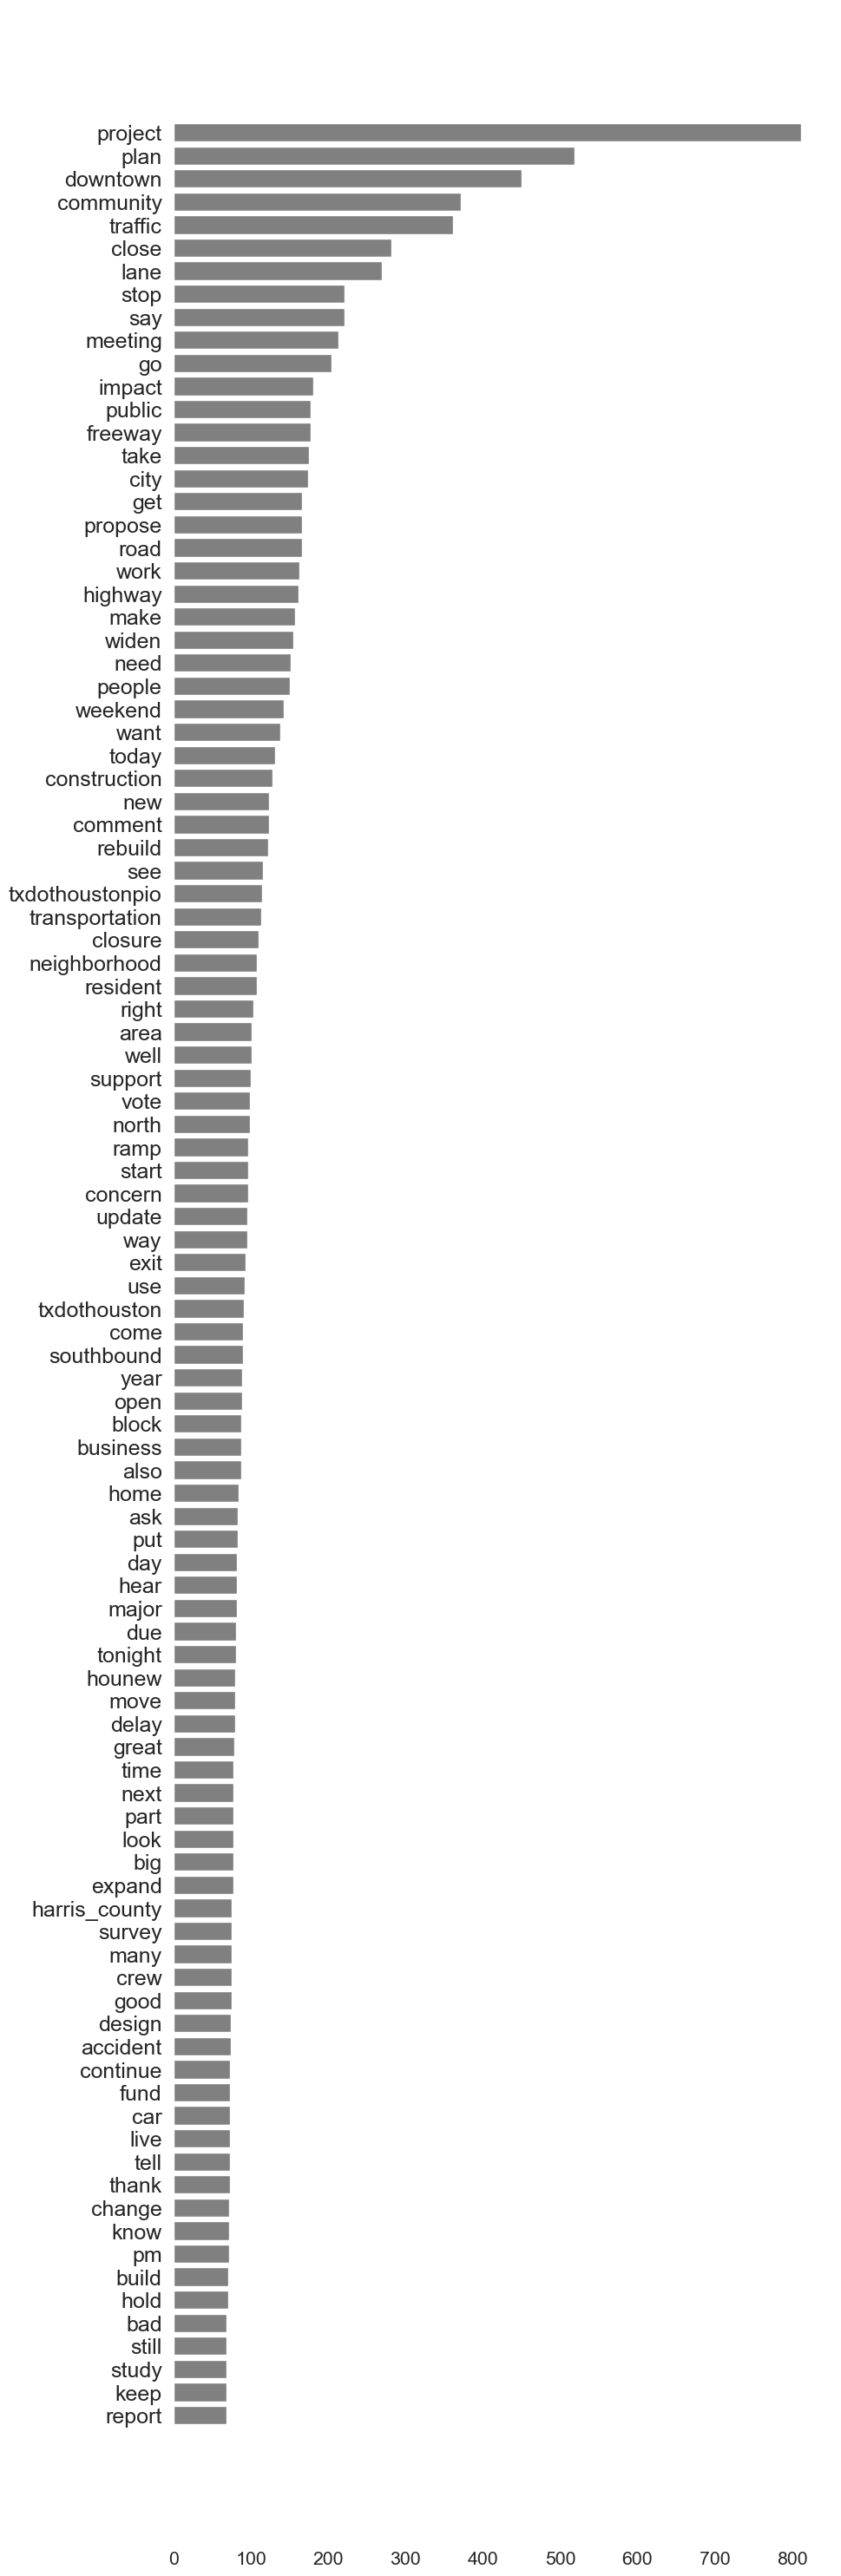

In [24]:
### total period ###
# data prep for viz
word_list = [item for sublist in df.text_prcd for item in sublist]
counts = dict(Counter(word_list).most_common(100))
labels, values = zip(*counts.items())
    
# sort your values in descending order
indSort = np.argsort(values)

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]
indexes = np.arange(len(labels))

sns.set_style("white")
fs=18
start=0
#start=0 to show all words
plt.figure(figsize=(10,30), tight_layout=1)
plt.barh(indexes,values,color='gray')
plt.yticks(indexes, labels, fontsize=fs)
plt.box(False)

### 4.2 Term frequency by periods

In [26]:
''' The whole tweets period was categorized into three periods based on the I-45 project events 
    to understand public opinions dynamics
    #period 1: Before 2015
    #period 2: 2015 to 2018
    #period 3: After 2018'''

df_1_1 = df[df.year<2015]
df_1_2 = df[(df.year==2015) & (df.month<4)]
df_1 = pd.concat([df_1_1, df_1_2])
df_1=df_1.reset_index()
df_1=df_1.drop(['index'], axis=1)

df_2_1 = df[(df.year==2015) & (df.month>3)]
df_2_2 = df[(df.year>2015) & (df.year<2019)]
df_2 = pd.concat([df_2_1, df_2_2])
df_2=df_2.reset_index()
df_2=df_2.drop(['index'], axis=1)

df_3 = df[df.year>2018]
df_3=df_3.reset_index()
df_3=df_3.drop(['index'], axis=1)

print(len(df),len(df_1),len(df_2),len(df_3))
print(len(df)-len(df_1)-len(df_2)-len(df_3))

4103 490 1035 2578
0


In [27]:
### period 1 ###
# data prep for visualization
word_list = [item for sublist in df_1.text_prcd for item in sublist]
counts = dict(Counter(word_list).most_common(50))
labels, values = zip(*counts.items())
    
# sort your values in descending order
indSort = np.argsort(values)

# rearrange your data
labels1 = np.array(labels)[indSort]
values1 = np.array(values)[indSort]
indexes1 = np.arange(len(labels))

### period 2 ###
# data prep for viz
word_list = [item for sublist in df_2.text_prcd for item in sublist]
counts = dict(Counter(word_list).most_common(50))
labels, values = zip(*counts.items())
    
# sort your values in descending order
indSort = np.argsort(values)

# rearrange your data
labels2 = np.array(labels)[indSort]
values2 = np.array(values)[indSort]
indexes2 = np.arange(len(labels))

### period 3 ###
# data prep for viz
word_list = [item for sublist in df_3.text_prcd for item in sublist]
counts = dict(Counter(word_list).most_common(50))
labels, values = zip(*counts.items())
    
# sort your values in descending order
indSort = np.argsort(values)

# rearrange your data
labels3 = np.array(labels)[indSort]
values3 = np.array(values)[indSort]
indexes3 = np.arange(len(labels))

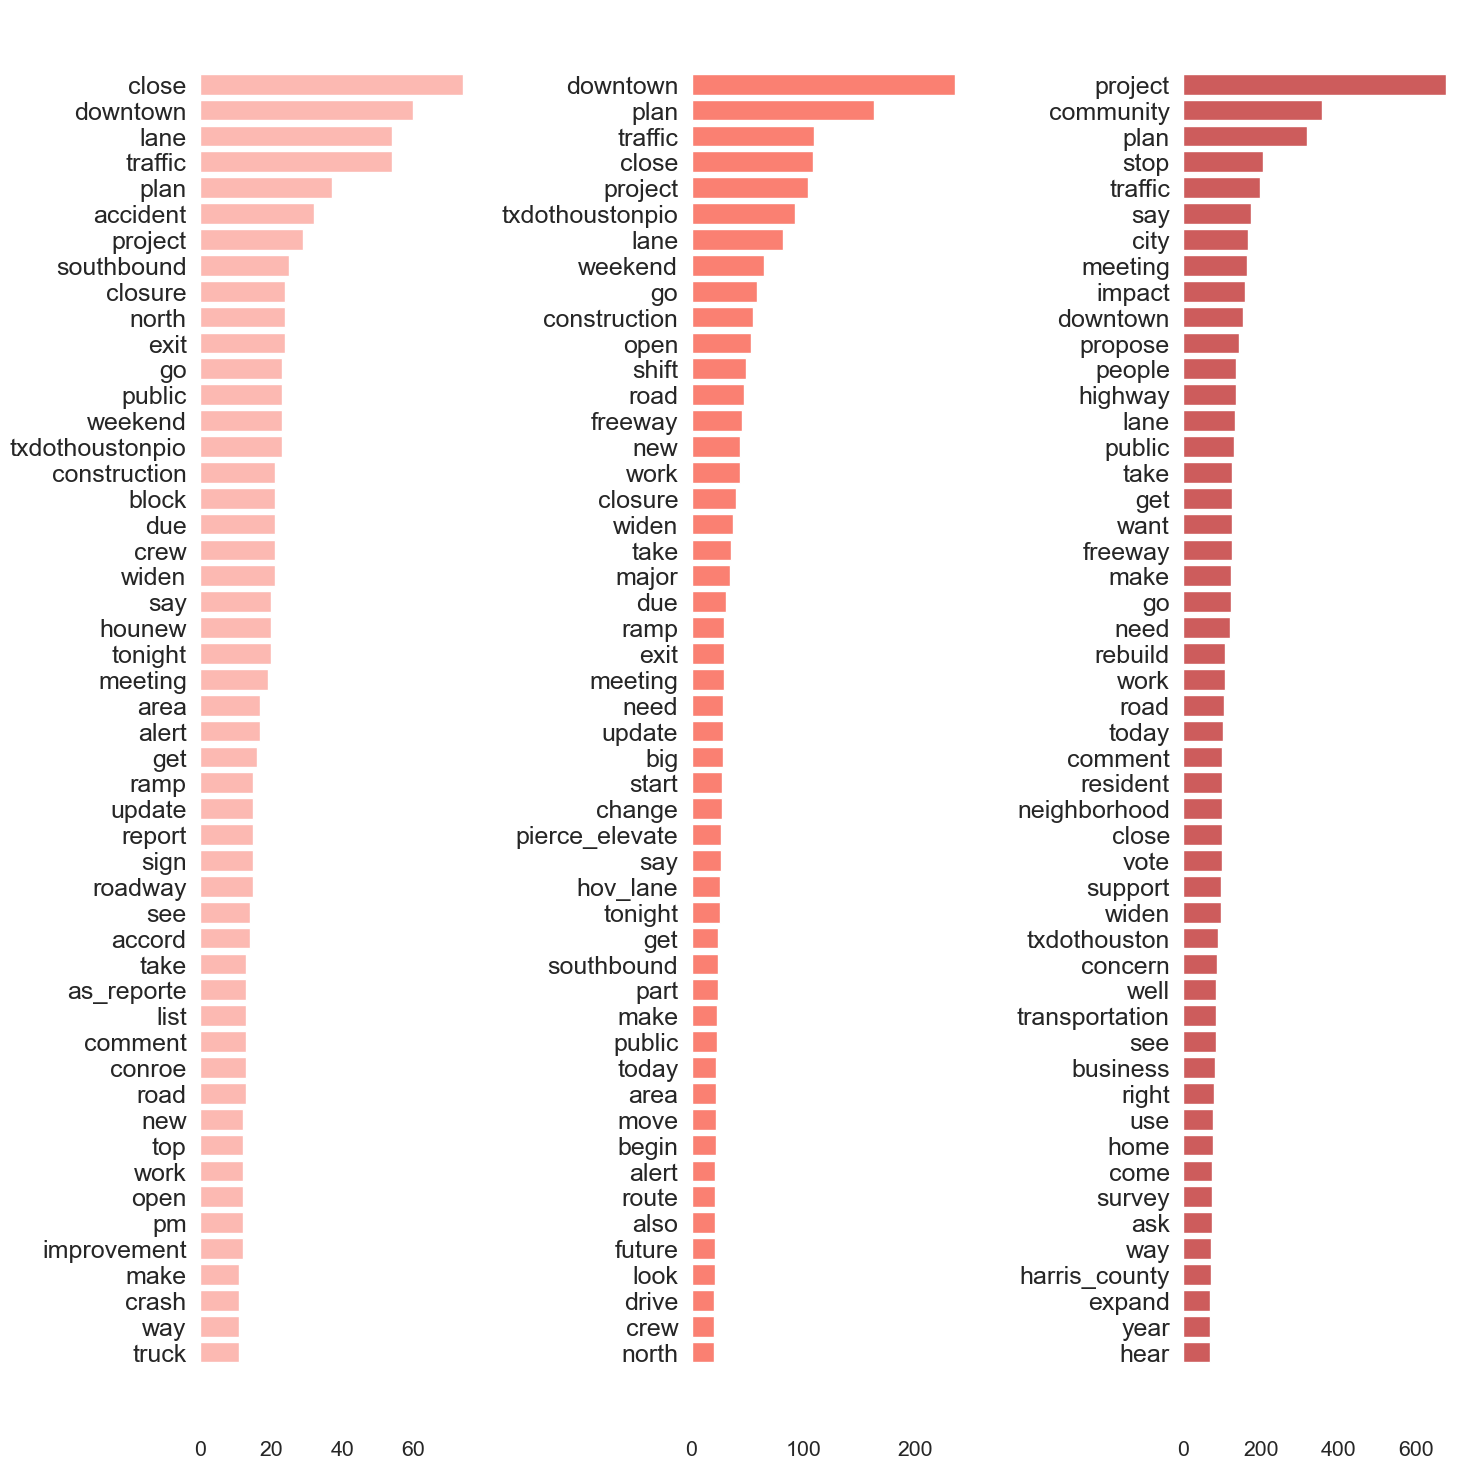

In [32]:
#Visualizing term frequency for each period
sns.set_style("white")
fs=18
start=-1
#start=0 to show all words
plt.figure(figsize=(15,15), tight_layout=1)


plt.subplot(1, 3, 1)
plt.barh(indexes1,values1,color='#fcb9b2')
#plt.text(values1,inexes1,str(values1))
plt.yticks(indexes1, labels1, fontsize=fs)
plt.box(False)

plt.subplot(1, 3, 2)
plt.barh(indexes2,values2,color='salmon')
plt.yticks(indexes2, labels2, fontsize=fs)
plt.box(False)

plt.subplot(1, 3, 3)
plt.barh(indexes3,values3,color='indianred')
plt.yticks(indexes3, labels3, fontsize=fs)
plt.box(False)

plt.show()

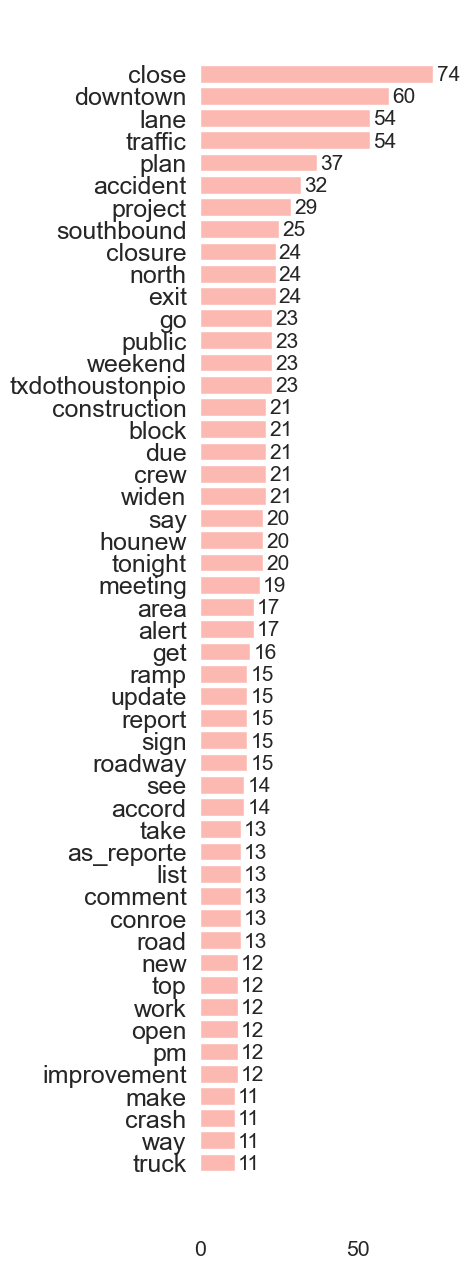

In [33]:
#Visualizing period 1 with frequency of each term
sns.set_style("white")
fs=18
plt.figure(figsize=(5,13), tight_layout=1)

plt.barh(indexes1,values1,color='#fcb9b2')
plt.yticks(indexes1, labels1, fontsize=fs)

for i in range(len(indexes1)):
    plt.text(values1[i]+1,indexes1[i]-0.3,str(values1[i]),fontsize=15)
    
plt.box(False)

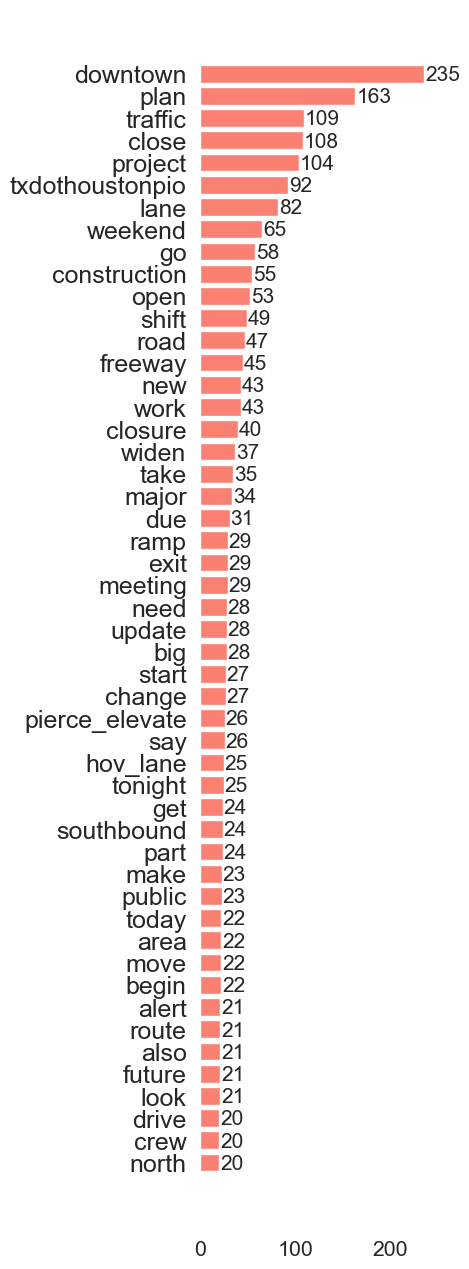

In [34]:
#Visualizing period 2 with frequency of each term
sns.set_style("white")
fs=18
plt.figure(figsize=(5,13), tight_layout=1)

plt.barh(indexes2,values2,color='salmon')
plt.yticks(indexes2, labels2, fontsize=fs)

for i in range(len(indexes2)):
    plt.text(values2[i]+1,indexes2[i]-0.3,str(values2[i]),fontsize=15)
    
plt.box(False)

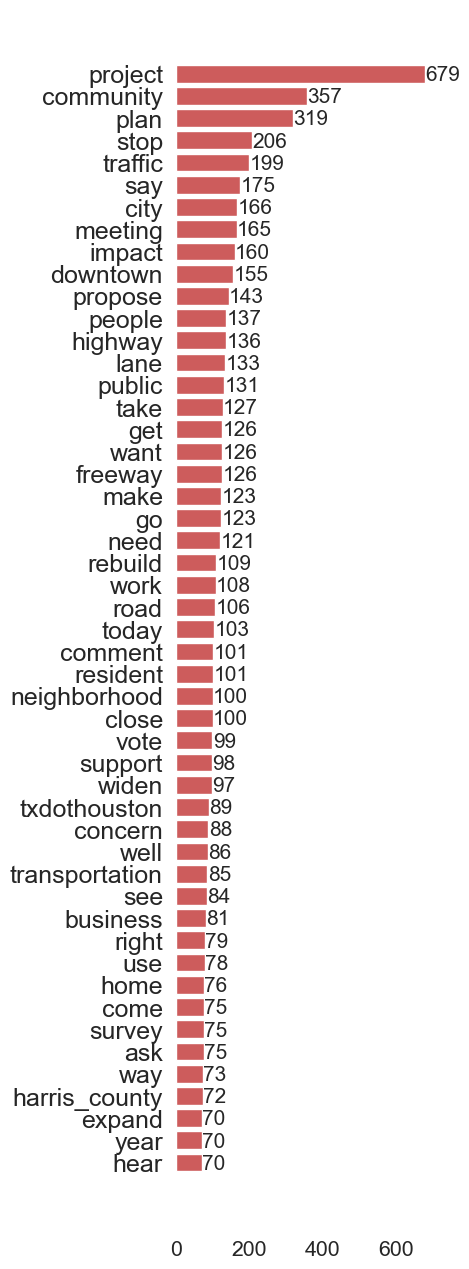

In [35]:
#Visualizing period 3 with frequency of each term
sns.set_style("white")
fs=18
plt.figure(figsize=(5,13), tight_layout=1)

plt.barh(indexes3,values3,color='indianred')
plt.yticks(indexes3, labels3, fontsize=fs)

for i in range(len(indexes3)):
    plt.text(values3[i]+1,indexes3[i]-0.3,str(values3[i]),fontsize=15)
    
plt.box(False)

In [39]:
#Extracting unique terms that only exist in one specific period
set(labels1)-set(labels2)-set(labels3)

{'accident',
 'accord',
 'as_reporte',
 'block',
 'conroe',
 'crash',
 'hounew',
 'improvement',
 'list',
 'pm',
 'report',
 'roadway',
 'sign',
 'top',
 'truck'}

In [40]:
set(labels2)-set(labels1)-set(labels3)

{'also',
 'begin',
 'big',
 'change',
 'drive',
 'future',
 'hov_lane',
 'look',
 'major',
 'move',
 'part',
 'pierce_elevate',
 'route',
 'shift',
 'start'}

In [41]:
set(labels3)-set(labels1)-set(labels2)

{'ask',
 'business',
 'city',
 'come',
 'community',
 'concern',
 'expand',
 'harris_county',
 'hear',
 'highway',
 'home',
 'impact',
 'neighborhood',
 'people',
 'propose',
 'rebuild',
 'resident',
 'right',
 'stop',
 'support',
 'survey',
 'transportation',
 'txdothouston',
 'use',
 'vote',
 'want',
 'well',
 'year'}

# 5. Topic modeling 

In [43]:
# Perform Topic Modeling using Gibbs sampling algorithm for a Dirichlet Mixture Model (GSDMM)
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print(' — — — — — — — — — ')

ModuleNotFoundError: No module named 'gsdmm'

In [ ]:
docs_1 = df.text_prcd.tolist()
vocab_1 = set(x for doc in docs_1 for x in doc)

print("Voc size:", len(vocab_1))
print("Number of documents:", len(docs_1))

vocab_1 = list(vocab_1)

In [37]:
# Select the optimal hyper parameter of GSDMM
mgp = MovieGroupProcess(K=10, alpha=0.1, beta=0.1, n_iters=100)

#vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab_1)
n_docs = len(docs_1)

# Fit the model on the data given the chosen seeds
y = mgp.fit(docs_1, n_terms)

In stage 0: transferred 3260 clusters with 10 clusters populated
In stage 1: transferred 1733 clusters with 10 clusters populated
In stage 2: transferred 1021 clusters with 10 clusters populated
In stage 3: transferred 803 clusters with 10 clusters populated
In stage 4: transferred 651 clusters with 10 clusters populated
In stage 5: transferred 589 clusters with 10 clusters populated
In stage 6: transferred 567 clusters with 10 clusters populated
In stage 7: transferred 523 clusters with 10 clusters populated
In stage 8: transferred 545 clusters with 10 clusters populated
In stage 9: transferred 503 clusters with 10 clusters populated
In stage 10: transferred 480 clusters with 10 clusters populated
In stage 11: transferred 492 clusters with 10 clusters populated
In stage 12: transferred 503 clusters with 10 clusters populated
In stage 13: transferred 512 clusters with 10 clusters populated
In stage 14: transferred 476 clusters with 10 clusters populated
In stage 15: transferred 472 clu

In [38]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topics :', doc_count)
print('*'*20)

# Topics sorted by document inside
top_index = doc_count.argsort()[-10:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)

# Show the top 5 words by cluster, it helps to make the topic_dict below
top_words(mgp.cluster_word_distribution, top_index, 30)

Number of documents per topics : [301 496 194 140 336 729 536 908 374  89]
********************
Most important clusters (by number of docs inside): [7 5 6 1 8 4 0 2 3 9]
********************
Cluster 7 : [('close', 207), ('houston', 179), ('downtown', 164), ('lane', 158), ('traffic', 156), ('weekend', 132), ('txdothoustonpio', 131), ('northbound', 120), ('closure', 118), ('north', 113), ('southbound', 102), ('road', 92), ('txdothouston', 84), ('pm', 84), ('crew', 79), ('open', 78), ('ramp', 77), ('exit', 76), ('south', 70), ('amp', 69), ('construction', 66), ('bridge', 65), ('work', 62), ('mainlane', 60), ('nb', 55), ('alert', 55), ('due', 52), ('plan', 50), ('update', 50), ('major', 50)]
 — — — — — — — — — 
Cluster 5 : [('houston', 217), ('project', 183), ('txdothouston', 111), ('amp', 111), ('plan', 109), ('city', 92), ('make', 86), ('highway', 86), ('need', 81), ('freeway', 77), ('people', 76), ('traffic', 75), ('lane', 71), ('downtown', 69), ('go', 68), ('community', 67), ('stop', 6

In [44]:
topic_dict = {}
topic_names = ['Project and People',
               'Public Meetings and Comments',
               'Construction and operations',
               'Traffic and downtown',
               'Redesign and impacts',
               'Accident and crashes',
               'Law and residents ',
               'Financial',
               'Closure',
               'Changes in plan',
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i]

NameError: name 'top_index' is not defined

In [45]:
Topic_numm = {'Project and People'          : 'Topic 0',
              'Public Meetings and Comments': 'Topic 1', 
              'Construction and operations' : 'Topic 2',
              'Traffic and downtown'        : 'Topic 3',
              'Redesign and impacts'        : 'Topic 4',
              'Accident and crashes'        : 'Topic 5',
              'Law and residents'           : 'Topic 6',
              'Financial'                   : 'Topic 7',
              'Closure'                     : 'Topic 8',
              'Changes in plan'             : 'Topic 9'}  

df['Topic_No'] = df['Topic_names'].map(Topic_numm)

KeyError: 'Topic_names'

In [50]:
def create_topics_dataframe(data_text=df.renderedContent,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=df.text_prcd):
    result = pd.DataFrame(columns=['Topic', 'text_prcd', ' renderedContent'])
    for i, text in enumerate(data_text):
        result.at[i, 'renderedContent'] = df.renderedContent[i]
        result.at[i, 'year'] = df.year[i]
        result.at[i, 'text_prcd'] = df.text_prcd[i]
        prob = mgp.choose_best_label(df.text_prcd[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

NameError: name 'mgp' is not defined

In [51]:
result = create_topics_dataframe(data_text=df.renderedContent, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=df.text_prcd)

NameError: name 'create_topics_dataframe' is not defined

In [52]:
topic_dfs = {}

for i, topic_name in enumerate(topic_names):
    topic_dfs[f'df_{i}'] = result[result.Topic == topic_name]

NameError: name 'result' is not defined

In [54]:
for j in range(10):
    trend_list = trend_dict[f'trend_{j}']
    sum_trend = np.sum(trend_list)
    normalized_trend = trend_list / sum_trend
    trend_dict[f'trend_{j}'] = trend_list

KeyError: 'trend_0'

In [55]:
for df in df_list:
    df_counts = []
    for i in topic_names:
        df_counts.append(len(df[df.Topic == i]))
    
    df_counts = df_counts / np.sum(df_counts)

NameError: name 'df_list' is not defined

NameError: name 'cip' is not defined

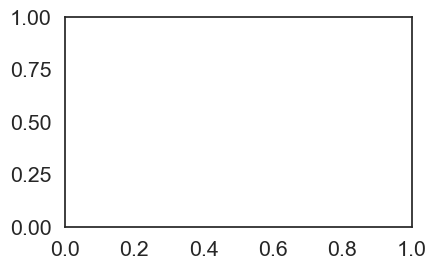

In [56]:
sns.set_style("white")
fs=18
start=0
#start=0 to show all words
plt.figure(figsize=(20,3), tight_layout=1)


plt.subplot(1, 5, 1)
plt.plot(cip,color='lightcoral',linewidth=4)
plt.vlines(7, 0, 12, colors='grey', linestyles='--')
plt.vlines(13, 0, 12, colors='grey', linestyles='--')
plt.ylim(0,0.6)
plt.yticks([0,0.2,0.4,0.6],fontsize=20)
#plt.ylabel('Nr. posts',fontsize=30)
plt.xticks([])
plt.box(False)

plt.subplot(1, 5, 2)
plt.plot(cl,color='lightsteelblue',linewidth=4)
plt.vlines(7, 0, 12, colors='grey', linestyles='--')
plt.vlines(13, 0, 12, colors='grey', linestyles='--')
plt.ylim(0,0.6)
plt.yticks([])
plt.xticks([])
plt.box(False)

plt.subplot(1, 5, 3)
plt.plot(cao,color='darkseagreen',linewidth=4)
plt.vlines(7, 0, 12, colors='grey', linestyles='--')
plt.vlines(13, 0, 12, colors='grey', linestyles='--')
plt.ylim(0,0.6)
plt.yticks([])
plt.xticks([])
plt.box(False)

plt.subplot(1, 5, 4)
plt.plot(far,color='plum',linewidth=4)
plt.vlines(7, 0, 12, colors='grey', linestyles='--')
plt.vlines(13, 0, 12, colors='grey', linestyles='--')
plt.ylim(0,0.6)
plt.yticks([])
plt.xticks([])
plt.box(False)

plt.subplot(1, 5, 5)
plt.plot(fl,color='darkgoldenrod',linewidth=4)
plt.vlines(7, 0, 12, colors='grey', linestyles='--')
plt.vlines(13, 0, 12, colors='grey', linestyles='--')
plt.ylim(0,0.6)
plt.yticks([])
plt.xticks([])
plt.box(False)

plt.show()

NameError: name 'nah' is not defined

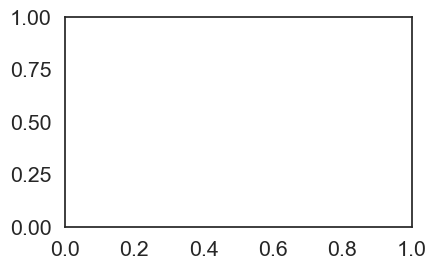

In [57]:
sns.set_style("white")
fs=18
start=0
#start=0 to show all words
plt.figure(figsize=(20,3), tight_layout=1)


plt.subplot(1, 5, 1)
plt.plot(nah,color='coral',linewidth=4)
plt.vlines(7, 0, 12, colors='grey', linestyles='--')
plt.vlines(13, 0, 12, colors='grey', linestyles='--')
plt.ylim(0,0.6)
plt.yticks([0,0.2,0.4,0.6],fontsize=20)
plt.xticks([])
plt.box(False)

plt.subplot(1, 5, 2)
plt.plot(pap,color='pink',linewidth=4)
plt.vlines(7, 0, 12, colors='grey', linestyles='--')
plt.vlines(13, 0, 12, colors='grey', linestyles='--')
plt.ylim(0,0.6)
plt.yticks([])
plt.xticks([])
plt.box(False)

plt.subplot(1, 5, 3)
plt.plot(pmac,color='forestgreen',linewidth=4)
plt.vlines(7, 0, 12, colors='grey', linestyles='--')
plt.vlines(13, 0, 12, colors='grey', linestyles='--')
plt.ylim(0,0.6)
plt.yticks([])
plt.xticks([])
plt.box(False)

plt.subplot(1, 5, 4)
plt.plot(rai,color='orange',linewidth=4)
plt.vlines(7, 0, 12, colors='grey', linestyles='--')
plt.vlines(13, 0, 12, colors='grey', linestyles='--')
plt.ylim(0,0.6)
plt.yticks([])
plt.xticks([])
plt.box(False)

plt.subplot(1, 5, 5)
plt.plot(tad,color='dodgerblue',linewidth=4)
plt.vlines(7, 0, 12, colors='grey', linestyles='--')
plt.vlines(13, 0, 12, colors='grey', linestyles='--')
plt.ylim(0,0.6)
plt.yticks([])
plt.xticks([])
plt.box(False)

plt.show()